In [ ]:
import os
import sys
import importlib
import pickle
import emcee
import corner
AbsPath = str(os.path.abspath(""))+"/.."
sys.path.append(AbsPath)
#from Scripts.Plots import SDSS_Plots
import scipy.stats
from itertools import cycle
#Add_SDSS = SDSS_Plots.SDSS_Plots(11.5,15,0.1)
import matplotlib.pyplot as plt
from Functions import Functions as F
HMF_fun = F.Make_HMF_Interp()
from Functions.Functions import Make_HMF_Interp
import numpy as np
import matplotlib.pyplot as plt
import colossus.halo.mass_adv as massdefs
from colossus.halo.mass_so import M_to_R
from halotools import empirical_models
from colossus.cosmology import cosmology
cosmology.setCosmology("planck15")
from astropy.cosmology import Planck15 as Cosmo_AstroPy
Cosmo =cosmology.getCurrent()


h = Cosmo.h

#Abundance Matching Parameters
Override =\
{\
'M10':12.0,\
'SHMnorm10':0.032,\
'beta10':1.5,\
'gamma10':0.56,\
'M11':0.6,\
'SHMnorm11':-0.014,\
'beta11':-2,\
'gamma11':0.08\
}


AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': False,\
'B18c':False,\
'B18t':False,\
'G18':False,\
'G18_notSE':False,\
'G19_SE':False,\
'G19_cMod':False,\
'Lorenzo18':False,\
'Moster': False,\
'Moster10': False,\
'Illustris': False,\
'z_Evo':True,\
'Scatter': 0.15,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT': False,\
'M_PFT1': False,\
'M_PFT2': False,\
'M_PFT3': False,\
'N_PFT1': False,\
'N_PFT2': False,\
'N_PFT3': False,\
'b_PFT1': False,\
'b_PFT2': False,\
'b_PFT3': False,\
'g_PFT1': False,\
'g_PFT2': False,\
'g_PFT3': False,\
'g_PFT4': False\
}

Paramaters = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
'SFR_Model': 'CE',\
'PreProcessing': False,\
'AltDynamicalTimeB': False\
}



#Subhalomass function parameters macc/M0
Unevolved = {\
'gamma' : 0.22,\
'alpha' : -0.91,\
'beta' : 6,\
'omega' : 3,\
'a' : 1,\
}

In [ ]:
from Scripts.Plots import SDSS_Plots

In [ ]:
Add_SDSS = SDSS_Plots.SDSS_Plots(11.5,15,0.1)

In [ ]:
Centrals_DF = Add_SDSS.df_cent.dropna()

In [ ]:
plt.hist2d(Centrals_DF.newMhaloL, Centrals_DF.MsMendSerExp, bins = [100, 100])
plt.xlim(12, 15)
plt.show()

In [ ]:
importlib.reload(F)

In [ ]:
#Load Tinker_HOD
Tkr_hod = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_hod.dat", skiprows=2).T
Tkr_RX2 = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_RX2.dat", skiprows=2).T
#Load STEEL
Fit = ('1.0', True, True, True, 'G19_DPL', 'G19_SE')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)



#Plot Full STEEL
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

AbnMtch[Fit[5]] = True
Central_Wt = HMF_fun(AvaHaloMass[Data_z_ix], 0.5)
SM = F.DarkMatterToStellarMass(AvaHaloMass[Data_z_ix]-np.log10(h), 0.5, Paramaters, ScatterOn=False)
Norm = scipy.stats.norm(SM, 0.15)
Prob = 1-Norm.cdf(11.45)
Central_Wt = Central_Wt*Prob
X_cen, Y_cen = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Central_Wt, Scatt = 0.1)
Y_cen = Y_cen*(10**4)
AbnMtch[Fit[5]] = False

#X_sat==X_cen
plt.plot(X_sat, Y_cen+Y_sat, "-",label ="STEEL", color = "C0")
plt.plot(X_cen, Y_cen, "--",label ="STEEL_cen", color = "C0")
plt.plot(X_sat, Y_sat, ":",label = "STEEL_sat", color = "C0")



#Central only toy model
Override['M10'] = 12.0
Override['SHMnorm10'] = 0.032
Override['beta10'] = 1.5
Override['gamma10'] = 0.58
Override['M11'] = 0.6
Override['SHMnorm11'] = -0.014
Override['beta11'] = -0.7
Override['gamma11'] = 0.08

AbnMtch['Override_z'] = True
Central_Wt = HMF_fun(AvaHaloMass[Data_z_ix], 0.5)
SM = F.DarkMatterToStellarMass(AvaHaloMass[Data_z_ix]-np.log10(h), 0.5, Paramaters, ScatterOn = False)
Norm = scipy.stats.norm(SM, 0.1)
Prob = 1-Norm.cdf(11.45)
Central_Wt = Central_Wt*Prob
X_cen, Y_cen = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Central_Wt, Scatt = 0.1)
Y_cen = Y_cen*(10**4)
AbnMtch['Override_z'] = False

plt.plot(X_cen, Y_cen, "--",label ="ToyMod", color = "C2")


#"""
plt.plot(Tkr_hod[0], Tkr_hod[1]+(Tkr_hod[2]/10), "-",label = "HOD", color = "C1")
plt.plot(Tkr_hod[0], Tkr_hod[1], "--",label = "HOD_cen", color = "C1")
plt.plot(Tkr_hod[0], Tkr_hod[2]/10, ":",label = "HOD_sat", color = "C1")
#"""
"""
plt.plot(Tkr_RX2[0], Tkr_RX2[1]+(Tkr_RX2[2]/10), "-",label = "HOD", color = "C2")
plt.plot(Tkr_RX2[0], Tkr_RX2[1], "--",label = "HOD_cen", color = "C2")
plt.plot(Tkr_RX2[0], (Tkr_RX2[2]/10), ":",label = "HOD_sat", color = "C2")
"""

plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.legend(frameon = False)
plt.show()



In [ ]:


#Load Tinker_HOD
Tkr_hod = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_hod.dat", skiprows=2).T
Tkr_RX2 = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_RX2.dat", skiprows=2).T


#Load STEEL
Fit = ('1.0', False, False, True, 'G19_DPL', 'Moster')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, "-.",label = "STEEL_Moster_frz", color = "C1")

Output = np.vstack((X_sat, Y_sat))


#Load STEEL
Fit = ('1.0', True, True, True, 'G19_DPL', 'G19_SE')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, ":",label = "STEEL_SE_evo", color = "C2")

Output = np.vstack((Output, Y_sat))

#Load STEEL
Fit = ('1.0', False, False, True, 'G19_DPL', 'G19_SE')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, ":",label = "STEEL_SE_frz", color = "C3")

Output = np.vstack((Output, Y_sat))

#Load STEEL
Fit = ('1.0', False, False, True, 'G19_DPL', 'G19_cMod')#('1.0', False, False, True, 'G19_DPL', 'G19_SE')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, "--",label = "STEEL_cMod_frz", color = "C4")

Output = np.vstack((Output, Y_sat))

#Load STEEL
Fit = ('1.0', True, False, True, 'Illustris', 'Illustris')
AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(Fit)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)

#Plot STEEL sat
Data_M_ix = np.digitize(11.45, bins = SM_Cuts)-1
Data_z_ix = np.digitize(0.5, bins = z)-1
print(SM_Cuts[Data_M_ix],z[Data_z_ix])
Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_M_ix][Data_z_ix], AvaHaloMassBins[Data_z_ix])
X_sat, Y_sat = F.Gauss_Scatt(AvaHaloMass[Data_z_ix], Y_Model, Scatt = 0.1)
Y_sat = Y_sat*(10**4)*(h**-3)

plt.plot(X_sat, Y_sat, "--",label = "STEEL_ill_strip", color = "C5")

Output = np.vstack((Output, Y_sat))

#HOD
plt.plot(Tkr_hod[0], Tkr_hod[2]/10, "-",label = "HOD_sat", color = "C0")
plt.plot(Tkr_RX2[0], (Tkr_RX2[2]/10), "-",label = "HOD_sat_RX2", color = "C7")

plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.legend(frameon = False)
plt.show()

np.savetxt("StewPaper.txt", Output)

In [ ]:
Output = np.loadtxt("StewPaper.txt")
M = Output[0]
M13_frz = Output[1]
SE_evo = Output[2]
SE_frz = Output[3]
cmod_frz = Output[4]
Ill_strip = Output[5]

In [ ]:
def ReturnCentralDist(HM_range, theta):
    Gamma, Gamma_z, Scatter = theta
    #Central only toy model
    #Args:
    #    HM_range: [Msun h-1]
    #    Gamma: SMHM high mass slope parameter
    #    Gamma_z: SMHM high mass slope evolution parameter
    #    Scatter: SMHM scatter parameter
    #Returns:
    #    Y_cen: Numberdensity of central galaxies above 10^11 as a fucntion of halo mass [h^3Mpc^{-3}dex^{-1}]x10^{-4}
    """
    Override['M10'] = 12.0
    Override['SHMnorm10'] = 0.032
    Override['beta10'] = 1.5
    Override['gamma10'] = Gamma#0.525
    Override['M11'] = 0.6
    Override['SHMnorm11'] = -0.014
    Override['beta11'] = -0.7
    Override['gamma11'] = Gamma_z#0.08
    """
    Override_lcl =\
    {\
    'M10':12.0,\
    'SHMnorm10':0.032,\
    'beta10':1.5,\
    'gamma10':Gamma,\
    'M11':0.6,\
    'SHMnorm11':-0.014,\
    'beta11':-0.7,\
    'gamma11':Gamma_z\
    }
    
    
    AbnMtch_lcl =\
    {\
    'Behroozi13': False,\
    'Behroozi18': False,\
    'B18c':False,\
    'B18t':False,\
    'G18':False,\
    'G18_notSE':False,\
    'G19_SE':False,\
    'G19_cMod':False,\
    'Lorenzo18':False,\
    'Moster': False,\
    'Moster10': False,\
    'Illustris': False,\
    'z_Evo':True,\
    'Scatter': 0.15,\
    'Override_0': False,\
    'Override_z': False,\
    'Override': Override_lcl,\
    'PFT': False,\
    'M_PFT1': False,\
    'M_PFT2': False,\
    'M_PFT3': False,\
    'N_PFT1': False,\
    'N_PFT2': False,\
    'N_PFT3': False,\
    'b_PFT1': False,\
    'b_PFT2': False,\
    'b_PFT3': False,\
    'g_PFT1': False,\
    'g_PFT2': False,\
    'g_PFT3': False,\
    'g_PFT4': False\
    }

    Paramaters_lcl = \
    {\
    'AbnMtch' : AbnMtch_lcl,\
    'AltDynamicalTime': 1,\
    'NormRnd': 0.5,\
    'SFR_Model': 'CE',\
    'PreProcessing': False,\
    'AltDynamicalTimeB': False\
    }
    
    AbnMtch_lcl['Override_z'] = True
    Central_Wt = HMF_fun(HM_range, 0.5)
    SM = F.DarkMatterToStellarMass(HM_range - np.log10(h), 0.5, Paramaters_lcl, ScatterOn = False)
    Norm = scipy.stats.norm(SM, Scatter)
    Prob = 1-Norm.cdf(11.45)
    Central_Wt = Central_Wt*Prob
    X_cen, Y_cen = F.Gauss_Scatt(HM_range, Central_Wt, Scatt = 0.1)
    Y_cen = Y_cen*(10**4)
    AbnMtch_lcl['Override_z'] = False
    return Y_cen

In [ ]:
#Load Tinker_HOD
Tkr_hod = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_hod.dat", skiprows=2).T
Tkr_RX2 = np.loadtxt(AbsPath+"/Data/Observational/Tinker_HOD/pdf_censat_RX2.dat", skiprows=2).T
plt.plot(Tkr_hod[0], Tkr_hod[1], ":",label = "HOD_sat", color = "C0")
theta = 0.55, 0.0, 0.1
Y = ReturnCentralDist(Tkr_hod[0], theta)



plt.plot(Tkr_hod[0], Y, label = "ToyMod", color = "C1")
plt.legend(frameon = False)
plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.show()

In [ ]:
gt12 = np.digitize(12, bins = Tkr_hod[0])-1
theta = 0.55, 0.0, 0.1
plt.plot(Tkr_hod[0][gt12:], Tkr_hod[1][gt12:], ":",label = "HOD_sat", color = "C0")


theta = 0.55, 0.0, 0.1
RMS = lnlike(theta, Tkr_hod[0][gt12:], Tkr_hod[1][gt12:])
Y = ReturnCentralDist(Tkr_hod[0][gt12:], theta)
plt.plot(Tkr_hod[0][gt12:], Y, label = str(theta)+str(round(RMS, 3)), color = "C1")


theta = 0.6, 0.0, 0.1
RMS = lnlike(theta, Tkr_hod[0][gt12:], Tkr_hod[1][gt12:])
Y = ReturnCentralDist(Tkr_hod[0][gt12:], theta)
plt.plot(Tkr_hod[0][gt12:], Y, label = str(theta)+str(round(RMS, 3)), color = "C2")


theta = 0.65, 0.0, 0.1
RMS = lnlike(theta, Tkr_hod[0][gt12:], Tkr_hod[1][gt12:])
Y = ReturnCentralDist(Tkr_hod[0][gt12:], theta)
plt.plot(Tkr_hod[0][gt12:], Y, label = str(theta)+str(round(RMS, 3)), color = "C3")


theta = 0.8, 0.0, 0.1
RMS = lnlike(theta, Tkr_hod[0][gt12:], Tkr_hod[1][gt12:])
Y = ReturnCentralDist(Tkr_hod[0][gt12:], theta)
plt.plot(Tkr_hod[0][gt12:], Y, label = str(theta)+str(round(RMS, 3)), color = "C4")

plt.legend(frameon = False)
plt.xlim(12, 15.5)
plt.xlabel("log $\mathrm{M_{halo} [hM_{\odot}]}$")
plt.ylabel("$\mathrm{n_{gal}(M_{halo}) [h^3Mpc^{-3}dex^{-1}]x10^{-4}}$")
plt.show()

In [ ]:
#MCMC Functions

#This is the likelyhood function
def lnlike(theta, HM, y):
    g, g_z, s = theta
    model = ReturnCentralDist(HM, theta)
    
    return -0.5*np.power(sum(y-model), 2)
    
    #RMS = 1 - np.divide(np.sqrt(np.sum(np.power(model-y, 2))), len(y))
    #return np.log(RMS)

#This is the log-prior function
def lnprior(theta):
    g, g_z, s = theta
    if (0.55<g<0.57) and (-0.2<g_z<0.2) and (0.01<s<0.2):
        return 0.0
    else:
        return -np.inf
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [ ]:
#set up initial conditions
ndim, nwalkers = 3, 100
pos = [[0.55,0.0, 0.1] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(Tkr_hod[0][gt12:], Tkr_hod[1][gt12:]), threads = 20)

In [ ]:
sampler.run_mcmc(pos, 500)
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$g$", "$g_z$", "$s$"])
fig.show()
#fig.savefig("triangle.png")

In [ ]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$g$", "$g_z$", "$s$"], color = "C0", smooth = True)
fig.show()

In [ ]:
import pickle

In [ ]:
samples =  pickle.load(open(AbsPath+"/Data/Model/Output/Other/SMHM_Fitting/MCMC_Chain_lz.pkl", 'rb'))

M, N, b, g = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))
print(M, N, b, g)
fig = corner.corner(samples, labels=["M", "N", r"$\beta$", r"$\gamma$"], truths = [M[0], N[0], b[0], g[0]],\
                    color = "C0", truth_color = "k", smooth = True, quantiles=[0.16, 0.84],\
                    show_titles = True, title_fmt= ".3f")
fig.savefig(AbsPath+"/Figures/SMHM_Fit/MCMC_plot_lz.png")
fig.savefig(AbsPath+"/Figures/SMHM_Fit/MCMC_plot_lz.pdf")
fig.show()

In [ ]:
samples =  pickle.load(open(AbsPath+"/Data/Model/Output/Other/SMHM_Fitting/MCMC_Chain_hz.pkl", 'rb'))

M, N, b, g = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),zip(*np.percentile(samples, [16, 50, 84],axis=0)))
print(M, N, b, g)
fig = corner.corner(samples, labels=[r"$M_z$", r"$N_z$", r"$\beta_z$", r"$\gamma_z$"], truths = [M[0], N[0], b[0], g[0]],\
                    color = "C0", truth_color = "k", smooth = True, quantiles=[0.16, 0.84],\
                   show_titles = True, title_fmt= ".3f")
fig.savefig(AbsPath+"/Figures/SMHM_Fit/MCMC_plot_hz.png")
fig.savefig(AbsPath+"/Figures/SMHM_Fit/MCMC_plot_hz.pdf")
fig.show()

In [ ]:
from Scripts.SMHM_Fit_MCMC import StellarMassFunction

In [ ]:
SMF_Class = StellarMassFunction()

In [ ]:
SMR = SMF_Class.StellarMassRange
SMF = SMF_Class.Bernardi_SDSS()[0]
plt.plot(SMR, SMF, "-C0")
cmod = SMF_Class.cModel_SDSS()[0]
plt.plot(SMR, cmod, "-C1")

SMF_z, z = SMF_Class.Davidzon_17(Corr = True)
plt.plot(SMR, SMF_z[0], "--C0")
SMF_z, z = SMF_Class.Davidzon_17(Corr = False)
plt.plot(SMR, SMF_z[0], "--C1")
plt.show()

In [ ]:
z

In [ ]:
import os
import sys
AbsPath = str(os.path.abspath(""))+"/.."
sys.path.append(AbsPath)
import matplotlib.pyplot as plt
import numpy as np
from Scripts.SMHM_Fit_MCMC import DM_to_SM, StellarMassFunction, HaloMassFunction, HaloMassToStellarMass

In [ ]:
SMF_class = StellarMassFunction()
Y_t, Y_t_e, Y_sat, Y_sat_e, Y_cen, Y_cen_e, Redshifts = SMF_class.Bernardi_SDSS()

In [ ]:
HMF_class = HaloMassFunction()
HMF_cen = HMF_class.hmf_vir(0.1)
Masses_Cen = HMF_class.HaloMassRange
Masses_Sat, HMF_sat, z_infall = HMF_class.SHMF_STEEL(0.11)
Flat_Sat = np.sum(HMF_sat, axis = 0)

In [ ]:
SMHM_class = HaloMassToStellarMass()
SMHM_Model = SMHM_class.Moster

In [ ]:
print(np.shape(HMF_cen))
print(np.shape(Masses_Cen))
print(np.shape(HMF_sat))
print(np.shape(Flat_Sat))

In [ ]:
Params = 11.925, 0.576, 0.032,-0.014, 1.639,-0.693, 0.532,0.03, 0.15 
print("Centrals")
SMF_Cen = DM_to_SM(SMF_class.StellarMassRange, SMF_class.SMR_BW, Masses_Cen, HMF_class.HMR_BW, HMF_cen, Params, 0.1, SMHM_Model)
print("Satellites")
SMF_Sat = DM_to_SM(SMF_class.StellarMassRange, SMF_class.SMR_BW, Masses_Sat, HMF_class.HMR_BW, Flat_Sat, Params, 0.1, SMHM_Model)
SMF_Tot = np.log10(np.power(10,SMF_Cen) + np.power(10,SMF_Sat))

In [ ]:
Y_t, Y_t_e, Y_sat, Y_sat_e, Y_cen, Y_cen_e

plt.plot(SMF_class.StellarMassRange, Y_cen, "xC0", label = "SDSS Cen")
plt.plot(SMF_class.StellarMassRange, Y_sat, "xC1", label = "SDSS Sat")
plt.plot(SMF_class.StellarMassRange, Y_t, "xk", label = "SDSS Tot")

plt.plot(SMF_class.StellarMassRange-0.15, SMF_Cen, "C0", label = "Cen")
plt.plot(SMF_class.StellarMassRange-0.15, SMF_Sat, "C1", label = "Sat")
plt.plot(SMF_class.StellarMassRange-0.15, SMF_Tot, "k", label = "Tot")
plt.legend()
plt.ylim(-6, -1.5)
plt.savefig("Test.png")
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
headaxislength = 4.5
headlength = 5
headwidth = 3

length = np.array([1])
N = len(length)
length = length.reshape(N, 1)
x = np.array([0, -headaxislength,-headlength, 0], np.float64)
x = x + np.array([0, 1, 1, 1]) * length
print("x:", x)
y = 0.5 * np.array([1, 1, headwidth, 0], np.float64)
y = np.repeat(y[np.newaxis, :], N, axis=0)
print("y:", y)
ii = [0, 1, 2, 3, 2, 1, 0, 0]
X = x[:, ii]
print("X:",X)
Y = y[:, ii]
Y[:, 3:-1] *= -1
print("Y,",Y)
plt.plot(X[0],Y[0])

x: [[ 0.  -3.5 -4.   1.   1. ]
 [ 0.  -2.5 -3.   2.   2. ]
 [ 0.  -1.5 -2.   3.   3. ]]
y: [[0.5 0.5 1.5 0.  0.5]
 [0.5 0.5 1.5 0.  0.5]
 [0.5 0.5 1.5 0.  0.5]]


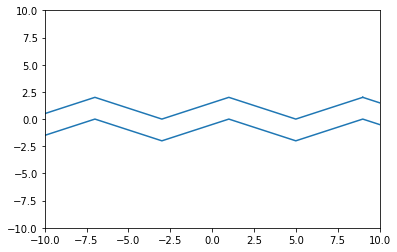

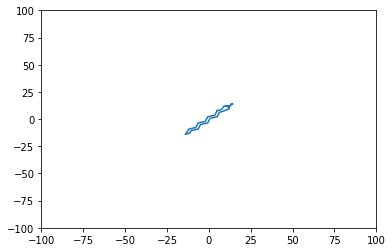

In [26]:
width = 1
theta = np.pi/4
headaxislength = 4.5*width
headlength = 5*width
headwidth = 3*width
head_pos = 'snake'
length = np.array([1, 2, 3])
N = len(length)
length = length.reshape(N, 1)
np.clip(length, 0, 2 ** 16, out=length)

segments = np.round(length, 0)

x = np.array([0, -headaxislength,-headlength, 0, 0], np.float64)
x = x + np.array([0, 1, 1, 1, 1]) * length
print("x:", x)
y = 0.5 * np.array([1, 1, headwidth, 0, 1], np.float64)
y = np.repeat(y[np.newaxis, :], N, axis=0)
print("y:", y)

if head_pos == 'tip':
    ii = [0, 1, 2, 3, 2, 1, 0, 0]
    X = x[:, ii]
    Y = y[:, ii]
    Y[:, 3:-1] *= -1
elif head_pos == 'middle':
    # Potential to add scalar variable here to fine tune head positioning
    ii = [0, 1, 2, 3, 4, 4, 3, 2, 1, 0, 0]
    X = x[:, ii]
    Y = y[:, ii]
    X[:, 1:4] *= 0.5
    X[:, 6:-2] *= 0.5
    X[:, 1:4] +=headlength/4
    X[:, 6:-2] +=headlength/4
    Y[:, 3] = np.ones(np.shape(Y[:, 3]))*0.5
    Y[:, 6] = np.ones(np.shape(Y[:, 6]))*0.5
    Y[:, 5:-1] *= -1
elif head_pos == 'tail':
    ii = [0, 2, 3, 4, 4, 3, 2, 0, 0]
    X = x[:, ii]
    Y = y[:, ii]
    X[:, 1:3] -= headlength*1.1
    X[:, 5:-2] -= headlength*1.1
    X[:, 1:3] -=length/2
    X[:, 5:-2] -=length/2
    Y[:, 2] = np.ones(np.shape(Y[:, 2]))*0.5
    Y[:, 5] = np.ones(np.shape(Y[:, 5]))*0.5
    Y[:, 4:-1] *= -1
elif head_pos == 'snake':
    head_x = np.array([0,1,4,5,4.75,4.9,4.9,4.6,4.6,4.75,5,6,6])
    head_y = np.array([1,1,2,1.25,1,1,0.7,0.7,1,1,1.25,0.5,0.1])
    tounge_x = np.array([7,8,8.6,9,8.6,9,8,7])
    tounge_y = np.array([-0.2,0.4,0.1,0.3,0,-0.3,0.2,-0.4])
    body_x = np.array([-2-4*i for i in range(1,2*np.max(segments)+1)])
    body_y = np.array([-2,0]*np.max(segments))
    tail_x = np.array([-4-8*np.max(segments),-7-8*np.max(segments),-4-8*np.max(segments)])
    tail_y = np.array([-1, 0, 1])
    mid = (np.max(tounge_x)-np.min(tail_x))/2
    X_corr = (np.max(tounge_x) - mid)
    
    X = np.repeat((np.concatenate((np.array([-2]),
                        head_x,
                        tounge_x,
                        np.flip(head_x),
                        np.array([-2]),
                        body_x,
                        tail_x,
                        np.flip(body_x),
                        np.array([-2])
                        ))-X_corr)[np.newaxis,:], N, axis = 0)*length
    Y = np.repeat(np.concatenate((np.array([2]),
                        head_y,
                        tounge_y,
                        -np.flip(head_y),
                        np.array([0]),
                        body_y,
                        tail_y,
                        np.flip(body_y)+2,
                        np.array([2])
                        ))[np.newaxis,:], N, axis = 0)*width

    
                             
    
    

plt.plot(X[0],Y[0])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()


xy = (X + Y * 1j) * np.exp(1j * theta) * width
XY = np.stack((xy.real, xy.imag), axis=2)


plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.plot(XY[:,:,0][0], XY[:,:,1][0])
plt.show()

In [ ]:
1 == 1.0

In [ ]:
head_pos = 1.0

In [ ]:
type(head_pos)

In [18]:
np.round?

Signature: np.round(a, decimals=0, out=None)
Docstring:
Round an array to the given number of decimals.

Refer to `around` for full documentation.

See Also
--------
around : equivalent function
File:      ~/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py
Type:      function


In [12]:
#P Grylls 2019 Abundance Matching Method

def PGrylls2019(M_halo,z,N_z,M_n_z,Beta_z,Gamma_z,N_01,M_n_01,Beta_01,Gamma_01):

	#Abundance matching functional form taken from: 
	#Predicting fully self-consistent satellite richness, galaxygrowth and starformation 
	#rates from the STasticalsEmi-Empirical modeL steel.Philip J. Grylls

	N = N_01 + N_z*((z-0.1)/(z+1)) # N as a function of z

	M_n = M_n_01 + M_n_z*((z-0.1)/(z+1)) # M_n as a function of z

	Beta = Beta_01 + Beta_z*((z-0.1)/(z+1)) # Beta as a function of z

	Gamma = Gamma_01 + Gamma_z*((z-0.1)/(z+1)) # Gamma as a function of z

	M_star = 2.0 * M_halo * N * ((M_halo/10**M_n)**(-1.0*Beta) + (M_halo/10**M_n)**Gamma)**(-1.0)

	return M_star

[1.00000000e+10 1.26485522e+10 1.59985872e+10 2.02358965e+10
 2.55954792e+10 3.23745754e+10 4.09491506e+10 5.17947468e+10
 6.55128557e+10 8.28642773e+10 1.04811313e+11 1.32571137e+11
 1.67683294e+11 2.12095089e+11 2.68269580e+11 3.39322177e+11
 4.29193426e+11 5.42867544e+11 6.86648845e+11 8.68511374e+11
 1.09854114e+12 1.38949549e+12 1.75751062e+12 2.22299648e+12
 2.81176870e+12 3.55648031e+12 4.49843267e+12 5.68986603e+12
 7.19685673e+12 9.10298178e+12 1.15139540e+13 1.45634848e+13
 1.84206997e+13 2.32995181e+13 2.94705170e+13 3.72759372e+13
 4.71486636e+13 5.96362332e+13 7.54312006e+13 9.54095476e+13
 1.20679264e+14 1.52641797e+14 1.93069773e+14 2.44205309e+14
 3.08884360e+14 3.90693994e+14 4.94171336e+14 6.25055193e+14
 7.90604321e+14 1.00000000e+15]
[59091.54458901656, 122131.89070264719, 252424.01766937136, 521708.8426679602, 1078246.3300083233, 2228399.7221756936, 4605113.299251202, 9515565.515752623, 19657505.3214304, 40591169.37340743, 83747800.05197398, 172516923.00022388, 354

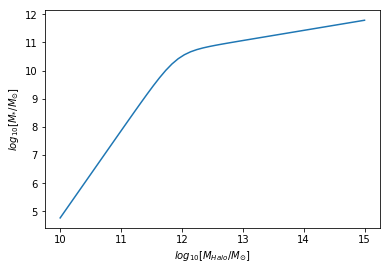

In [13]:
#IMPORTS################################################
import numpy as np
import matplotlib.pyplot as plt
########################################################

halomassrange = np.logspace(10,15,num=50) #halomasses in units of solar masses
galaxymasses = []

for i in halomassrange: # calc galaxy mass for each halo mass
	#values of constants and other terms from PGrylls 2019 paper
	galaxymasses.append(PGrylls2019(i,0.1,-0.018,0.52,-1.03,0.084,0.029,11.91,2.09,0.64)) 

loggalaxymasses = np.log10(galaxymasses) #take log of the masses
loghalomasses = np.log10(halomassrange)


plt.plot(loghalomasses,loggalaxymasses) # plot logged mass relation
plt.ylabel('$log_{10}[M_{*}/M_{\odot}]$')
plt.xlabel('$log_{10}[M_{Halo}/M_{\odot}]$')
plt.show()